# Phase 5 Capstone Project
## Neural Style Transfer
### Authored by Trinity Gahagen
---
---

# Table of Contents

# Brief EDA
---

In [1]:
# Basic imports
import numpy as np
import os
import matplotlib.pyplot as plt
import re

# Image tool imports
from PIL import Image, ImageOps
import cv2

# Deep learning imports
import tensorflow as tf
import tensorflow_hub as hub
import h5py

In [2]:
CONTENT_DIRECTORY = "images/content/"
STYLES_DIRECTORY = "images/styles/"

In [3]:
# Look at the list of content images
content_names = os.listdir(CONTENT_DIRECTORY)
content_names

['beach.jpg',
 'bird_at_beach.jpg',
 'cat.jpg',
 'desert_1.jpg',
 'desert_2.jpg',
 'desert_3.jpg',
 'flower.jpg',
 'octopus.jpg',
 'person.jpg',
 'seashell.jpg',
 'sunset.jpg']

In [4]:
# Look at the list of style images
style_names = os.listdir(STYLES_DIRECTORY)
style_names

["at_the_water's_edge_.jpg",
 'chateau_noir_.jpg',
 'dance_hall_bellevue__obverse__.a.jpg',
 'el_rio_de_luz_(the_river_of_light)_.jpg',
 'flecks_of_foam_.jpg',
 'genesis_ii_.jpg',
 'glass_and_checkerboard_.jpg',
 'haystacks_in_brittany_.jpg',
 'keelmen_heaving_in_coals_by_moonlight_.jpg',
 'landscape_.jpg',
 'lumber_schooners_at_evening_on_penobscot_bay_.jpg',
 'melon_and_lemon_.jpg',
 'moonlight_.jpg',
 'new_york_.jpg',
 'place_du_carrousel,_paris_.jpg',
 'political_drama_.jpg',
 'red_path,_st._prex_.jpg',
 'salem_cove_.jpg',
 'seascape_(gravelines)_.jpg',
 'swiss_landscape_.jpg',
 'the_bend_in_the_road_.jpg',
 'the_evening_of_the_deluge_.jpg',
 'the_harvest_.jpg',
 'the_houses_of_parliament,_sunset_.jpg',
 'the_island_of_raguenez,_brittany_.jpg',
 'the_olive_orchard_.jpg',
 'the_peppermint_bottle_.jpg',
 'the_visit_-_couple_and_newcomer_.jpg',
 'the_watering_can_(emblems__the_garden)_.jpg',
 'two_poplars_in_the_alpilles_near_saint_-_remy_.jpg',
 'venice_.jpg',
 'weasels_at_play_.jpg'

In [5]:
# Create a list of paths for all images in each directory
style_paths = [os.path.join(STYLES_DIRECTORY, name) for name in style_names]
content_paths = [os.path.join(CONTENT_DIRECTORY, name) for name in content_names]

### How many images are in each folder?

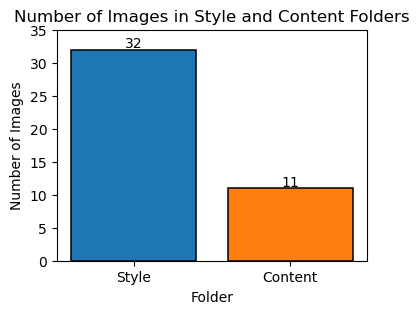

In [6]:
# List 
fig, ax = plt.subplots(figsize=(4, 3))
ax.bar(x=[0, 1], height=[len(style_names), len(content_names)], lw=1.1, edgecolor='black', color=['tab:blue', 'tab:orange'])
ax.set_ylim(0, 35)
ax.annotate(len(style_names),
            xy=(0, len(style_names) + 0.025 * 35),
            va='center',
            ha='center')
ax.annotate(len(content_names),
            xy=(1, len(content_names) + 0.025 * 35),
            va='center',
            ha='center')
ax.set_xticks([0, 1], labels=['Style', 'Content'])
ax.set_ylabel('Number of Images')
ax.set_title('Number of Images in Style and Content Folders')
ax.set_xlabel('Folder');

There are 32 images in the styles folder and 11 images in the content folder.

In [57]:
example_styles = [Image.open(path) for path in style_paths[:9]]

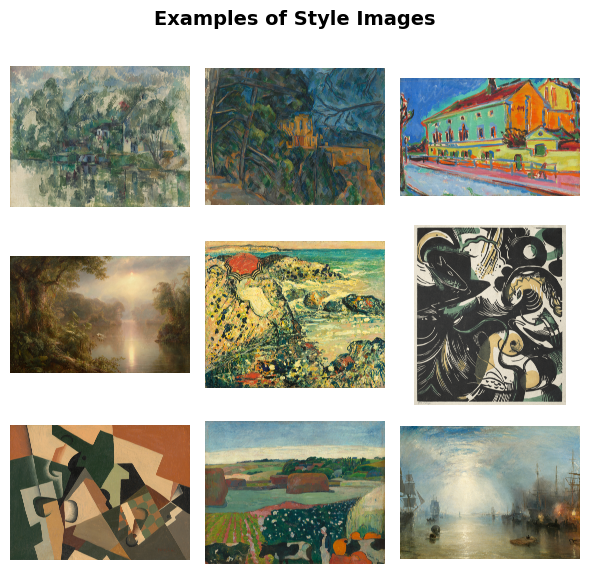

In [58]:
fig, axes = plt.subplots(3, 3, figsize=(6, 6))
fig.suptitle('Examples of Style Images', weight='bold', size=14)
for i in range(9):
    ax = axes[i // 3, i % 3]
    ax.set_axis_off()
    ax.imshow(example_styles[i])
plt.tight_layout();

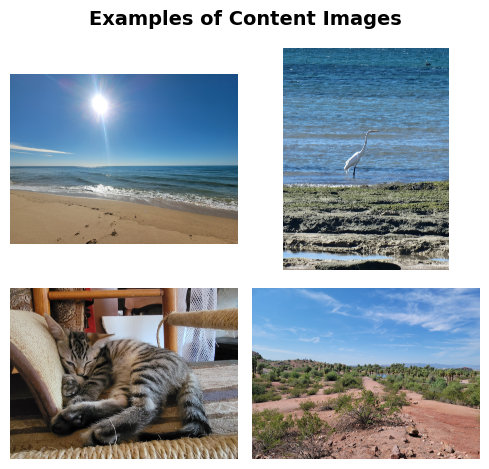

In [59]:
example_content = [ImageOps.exif_transpose(Image.open(path)) for path in content_paths[:4]]

fig, axes = plt.subplots(2, 2, figsize=(5, 5))
fig.suptitle('Examples of Content Images', weight='bold', size=14)
for i in range(4):
    ax = axes[i // 2, i % 2]
    ax.set_axis_off()
    ax.imshow(example_content[i])
plt.tight_layout();

# Demonstrating Neural Style Transfer Using TensorflowHub

The following code snippet was copied and slightly adapted from [*this*](https://dev.to/chefgideon/unlocking-artistry-a-guide-to-neural-style-transfer-34g6) website, and will be used to demonstrate the general direction of this project.

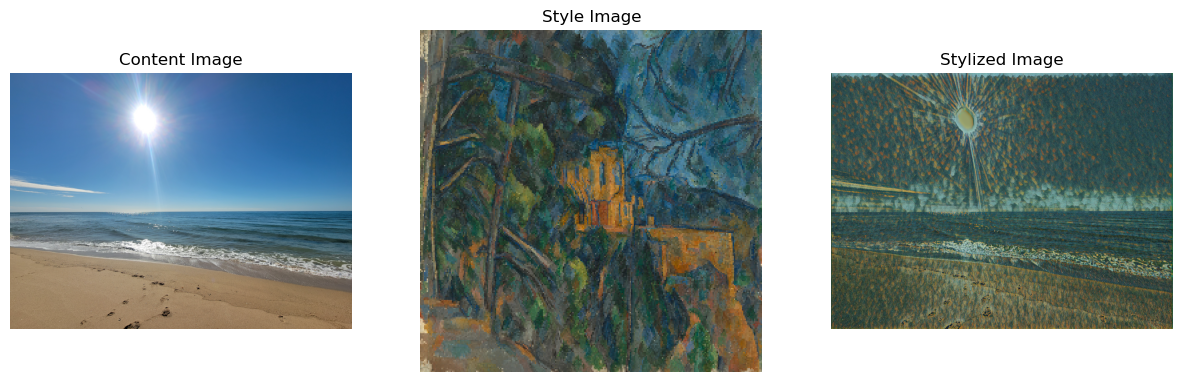

In [36]:
def preprocess_and_view_image(content_image_path, style_image_path, save_path=None):
    content_image = plt.imread(content_image_path)
    style_image = plt.imread(style_image_path)
    content_image = content_image.astype(np.float32)[np.newaxis, ...] / 255.
    style_image = style_image.astype(np.float32)[np.newaxis, ...] / 255.

    style_image = tf.image.resize(style_image, [256, 256])
    hub_module = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')
    outputs = hub_module(tf.constant(content_image), tf.constant(style_image))
    stylized_image = outputs[0]
    stylized_image_array = stylized_image.numpy()
    stylized_image_array = np.clip(stylized_image_array, 0, 1)

    plt.figure(figsize=(15, 5))
    plt.subplot(131)
    plt.imshow(content_image[0])
    plt.title('Content Image')
    plt.axis(False)
    plt.subplot(132)
    plt.imshow(style_image[0])
    plt.title('Style Image')
    plt.axis(False)
    plt.subplot(133)
    plt.imshow(stylized_image_array[0])
    plt.title('Stylized Image')
    plt.axis(False)
    plt.show()

random_content = content_paths[np.random.randint(0, 11)]
random_style = style_paths[np.random.randint(0, 33)]
preprocess_and_view_image(random_content, random_style, 'output_image.jpg')

While this method technically does the job, it doesn't really capture the style of the style image very well. It seemingly just creates a style-inspired filter and overlays it onto the original content image. Let's see how we can create a more refined combination of the two images.

# Creating a More Customized Architecture (Using VGG19)

According to Gatys et. al, the original creators of the neural style transfer algorithm, they used a normalized version of the VGG-19 Convolutional Neural Network to create the stylized images. The authors mention that they

> normalized the network by scaling the weights such that the mean activation of each convolutional filter over images and positions is equal to one.

They also mention that

> replacing the maximum pooling operation by average pooling yields slightly more appealing results

In [11]:
# Load the pre-trained VGG-19 model, without the fully connected dense layers
vgg = tf.keras.applications.VGG19(include_top=False)

In [12]:
vgg.layers

[<InputLayer name=input_layer, built=True>,
 <Conv2D name=block1_conv1, built=True>,
 <Conv2D name=block1_conv2, built=True>,
 <MaxPooling2D name=block1_pool, built=True>,
 <Conv2D name=block2_conv1, built=True>,
 <Conv2D name=block2_conv2, built=True>,
 <MaxPooling2D name=block2_pool, built=True>,
 <Conv2D name=block3_conv1, built=True>,
 <Conv2D name=block3_conv2, built=True>,
 <Conv2D name=block3_conv3, built=True>,
 <Conv2D name=block3_conv4, built=True>,
 <MaxPooling2D name=block3_pool, built=True>,
 <Conv2D name=block4_conv1, built=True>,
 <Conv2D name=block4_conv2, built=True>,
 <Conv2D name=block4_conv3, built=True>,
 <Conv2D name=block4_conv4, built=True>,
 <MaxPooling2D name=block4_pool, built=True>,
 <Conv2D name=block5_conv1, built=True>,
 <Conv2D name=block5_conv2, built=True>,
 <Conv2D name=block5_conv3, built=True>,
 <Conv2D name=block5_conv4, built=True>,
 <MaxPooling2D name=block5_pool, built=True>]

I'm going to try adjusting the pooling layers by replacing the Max Pooling with Average Pooling, but I don't really know how this is going to affect the model. I don't know if it will break it.

In [27]:
AveragePooling2D = tf.keras.layers.AveragePooling2D
layers = tf.keras.layers
Sequential = tf.keras.models.Sequential
Model = tf.keras.models.Model

In [22]:
adjusted_model_layers = []

for layer in vgg.layers:
    if isinstance(layer, layers.MaxPooling2D):
        adjusted_model_layers.append(AveragePooling2D(strides=layer.strides, pool_size=layer.pool_size, padding=layer.padding, name=layer.name))
    else:
        adjusted_model_layers.append(layer)

for layer in adjusted_model_layers:
    print(layer)

<InputLayer name=input_layer, built=True>
<Conv2D name=block1_conv1, built=True>
<Conv2D name=block1_conv2, built=True>
<AveragePooling2D name=block1_pool, built=False>
<Conv2D name=block2_conv1, built=True>
<Conv2D name=block2_conv2, built=True>
<AveragePooling2D name=block2_pool, built=False>
<Conv2D name=block3_conv1, built=True>
<Conv2D name=block3_conv2, built=True>
<Conv2D name=block3_conv3, built=True>
<Conv2D name=block3_conv4, built=True>
<AveragePooling2D name=block3_pool, built=False>
<Conv2D name=block4_conv1, built=True>
<Conv2D name=block4_conv2, built=True>
<Conv2D name=block4_conv3, built=True>
<Conv2D name=block4_conv4, built=True>
<AveragePooling2D name=block4_pool, built=False>
<Conv2D name=block5_conv1, built=True>
<Conv2D name=block5_conv2, built=True>
<Conv2D name=block5_conv3, built=True>
<Conv2D name=block5_conv4, built=True>
<AveragePooling2D name=block5_pool, built=False>


In [29]:
adjusted_vgg = Sequential(adjusted_model_layers)

for layer in adjusted_vgg.layers:
    print(layer.name)

block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [16]:
# Sanity check
for layer in adjusted_vgg.layers:
    print(layer.get_weights())

[array([[[[ 0.34119523,  0.09563112,  0.0177449 , ..., -0.11436455,
          -0.05099866, -0.00299793],
         [ 0.46418372,  0.03355668,  0.10245045, ..., -0.06945956,
          -0.04020201,  0.04048637],
         [ 0.39416704, -0.08419707, -0.03631314, ..., -0.10720515,
          -0.03804016,  0.04690642]],

        [[ 0.33999205,  0.13363543,  0.02129423, ..., -0.13025227,
          -0.16508926, -0.06969624],
         [ 0.41810837,  0.05260524,  0.09755926, ..., -0.09385028,
          -0.20492788, -0.0573062 ],
         [ 0.37740308, -0.07876257, -0.04775979, ..., -0.11827433,
          -0.19008617, -0.01889699]],

        [[-0.04484424,  0.06471398, -0.07631404, ..., -0.12629718,
          -0.29905206, -0.2825364 ],
         [-0.04806903, -0.00658076, -0.02234544, ..., -0.0878844 ,
          -0.3915486 , -0.34632796],
         [-0.04594866, -0.11583115, -0.14462094, ..., -0.12290562,
          -0.35782176, -0.27979308]]],


       [[[ 0.23215917,  0.133657  ,  0.12134422, ..., -

# Testing something out
---

In [17]:
# Load the pre-trained VGG-19 model for testing
vgg_test = tf.keras.applications.VGG19(include_top=True)

new_model_layers = []

for layer in vgg_test.layers:
    if isinstance(layer, layers.MaxPooling2D):
        new_model_layers.append(AveragePooling2D(strides=layer.strides, pool_size=layer.pool_size, padding=layer.padding, name=layer.name))
    else:
        new_model_layers.append(layer)

test_model = Sequential(new_model_layers)

In [18]:
def load_image(image_path, MAX_DIMENSIONS=512):
  """ Custom function to load image as data for visualization. """
  image = tf.io.read_file(image_path)
  image = tf.image.decode_image(image, channels=3)
  image = tf.image.convert_image_dtype(image, tf.float32)
  image_shape = tf.cast(tf.shape(image)[:-1], tf.float32)
  LONGEST_DIMENSIONS = max(image_shape)
  scale = MAX_DIMENSIONS / LONGEST_DIMENSIONS
  new_shape = tf.cast(image_shape * scale, tf.int32)
  image = tf.image.resize(image, new_shape)
  image = image[tf.newaxis, :]
  return image

In [19]:
content_image = load_image('images/content/cat.jpg')

input_image = tf.keras.applications.vgg19.preprocess_input(content_image * 255)
input_image = tf.image.resize(input_image, (224, 224))

vgg_pred_prob = vgg_test(input_image)
test_pred_prob = test_model(input_image)

top_five_vgg = tf.keras.applications.vgg19.decode_predictions(vgg_pred_prob.numpy())[0]
top_five_test = tf.keras.applications.vgg19.decode_predictions(test_pred_prob.numpy())[0]

In [20]:
[(class_name, probability) for (_, class_name, probability) in top_five_vgg]

[('tabby', 0.53076977),
 ('tiger_cat', 0.17874275),
 ('Egyptian_cat', 0.10323322),
 ('radiator', 0.006089985),
 ('rocking_chair', 0.005685275)]

In [21]:
[(class_name, probability) for (_, class_name, probability) in top_five_test]

[('tabby', 0.080251575),
 ('tiger_cat', 0.07173905),
 ('Egyptian_cat', 0.066478945),
 ('mousetrap', 0.025986018),
 ('spindle', 0.022289658)]

---

The model doesn't seem to break by changing the pooling layers from MaxPooling to AveragePooling, but it definitely tanks the accuracy. However, I don't know if we need accuracy since we just want to extract relevant features that can represent the content and style images respectively. We'll keep both models for further research.

# Architecture Building: Part 1

For now, we will attempt to get a model working that can successfully perform style transfer.

In [72]:
# In the original paper, the authors chose the 2nd convolutional layer in the 4th block
# as the layer from which the content is extracted
content_layer = ['block4_conv2']

# Style layers were chosen as the first convolutional layer in each block
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']

In [90]:
def extract_intermediate_features(model=vgg, layer_names=None):
    outputs = [model.get_layer(layer).output for layer in layer_names]
    extractor_model = Model([model.input], outputs)
    return extractor_model

def convert_to_model_input(image_path, IMAGE_HEIGHT = 224, IMAGE_WIDTH = 224):
    raw_image = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(raw_image)
    img = tf.image.resize(img, [IMAGE_HEIGHT, IMAGE_WIDTH])
    img = tf.expand_dims(img, axis=0)
    img = tf.keras.applications.vgg19.preprocess_input(img)
    return img

In [91]:
CAT_PATH = "images/content/cat.jpg"

img = convert_to_model_input(CAT_PATH)

style_extractor_model = extract_intermediate_features(vgg, style_layers)
content_extractor_model = extract_intermediate_features(vgg, content_layer)

style_outputs = style_extractor_model(img)
content_output = content_extractor_model(img)

In [ ]:
def gram_matrix(input_tensor):
  tensor_copy = input_tensor
  tensor_copy = tf.squeeze(tensor_copy)

  

# External Sources
---
L. A. Gatys, A. S. Ecker and M. Bethge, "Image Style Transfer Using Convolutional Neural Networks," 2016 IEEE Conference on Computer Vision and Pattern Recognition (CVPR), Las Vegas, NV, USA, 2016, pp. 2414-2423, doi: 10.1109/CVPR.2016.265. keywords: {Image reconstruction;Neural networks;Image representation;Semantics;Neuroscience;Feature extraction;Visualization},

https://www.tensorflow.org/tutorials/generative/style_transfer

https://www.datacamp.com/tutorial/implementing-neural-style-transfer-using-tensorflow